In [23]:
import os
import csv
import yaml

import matplotlib as mpl
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

In [3]:
pd.__version__
plt.rcParams['figure.dpi'] = 200
plt.rcParams['savefig.dpi'] = 200

In [4]:
AARM_DEVICES = {
    "jetson_cpu": "Nvidia Jetson CPU Only",
    "jetson_gpu": "Nvidia Jetson GPU Enabled", 
#     "rpi4_cpu": "Raspberry Pi 4B"
} # pi3_cpu

x86_DEVICES= {
    "herron_cpu": "Server Intel Xeon",
    "herron_gpu": "Server Nvidia RTX-8000",
    "laptop_cpu": "Laptop Intel-i7 (8th Generation)"
}

SEQ_LENGTHS = [2 ** seqlen for seqlen in range(10)]

In [18]:
BASELINE_TRANSFORMERS = {
    "bert": "BERT-Base",
    "roberta": "RoBERTa"
}

OTHER_TRANSFORMERS = {
    'longformer': "Longformer",
    'deberta': "DeBERTa",
    'albert': "Albert",
    'ibert': "ibert"
}

EFFICIENT_TRANSFORMERS = {
    "distilbert": "DistilBERT",
    "mobile_bert": "MobileBERT",
    "squeeze_bert": "SqueezeBERT",
    "funnel_transformer": "Funnel Transformer"
}

In [6]:
BASELINE_VISUAL = {
    "resnet18": "ResNet-18",
    "squeezenet": "SqueezeNet",
    "vgg16": "VGG16",
    "vit32": "ViT32",
    "alexnet": "AlexNet",
    "densenet": "DenseNet",
    "inception": "InceptionNet",
    "googlenet": "GoogLeNet",
    "shufflenet": "ShuffleNet",
    "resnext50_32x4d": "ResNext50",
    "wide_resnet50_2": "Wide ResNet-50"
}

EFFICIENT_VISUAL = {
    "efficientnet": "EfficientNet",
    "efficientnet_lite": "EfficientNet Lite",
    "gernet": "GErNet", 
    "squeezenet": "SqueezeNet", 
    "mobilenet_v2": "MobileNet v2",
    "mnasnet": "MNAS Net"
    }

In [41]:
DEVICE_LIST = {**x86_DEVICES}
LANGUAGE_MODELS = {**EFFICIENT_TRANSFORMERS, **BASELINE_TRANSFORMERS, **OTHER_TRANSFORMERS } #, **BASELINE_VISUAL}
VISION_MODELS = {**BASELINE_VISUAL, **EFFICIENT_VISUAL}

MODELS = EFFICIENT_TRANSFORMERS

In [10]:
VISUAL_DIR = "experiments/0903_vision"
LANGUAGE_DIR = "experiments/0903_transformers"

vision_results = pd.concat([
    pd.read_csv(os.path.join(VISUAL_DIR, f"{device}.csv"))
    for device in DEVICE_LIST.keys()
])

language_results = pd.concat([
    pd.read_csv(os.path.join(LANGUAGE_DIR, f"{device}.csv"))
    for device in DEVICE_LIST.keys()
])

all_results = pd.concat([vision_results, language_results])

In [ ]:
device_specs = {}
for device in DEVICE_LIST:
    device_specs[device] = yaml.load(open(f"config/devices/{device}.yaml", "rb"))
    

In [32]:
device_specs

{'jetson_cpu': {'MaxPowerUsage': 10,
  'OS': 'ubuntu1804',
  'Isa': 'aarm64',
  'Cpu': 'Cortex-A57',
  'CudaArchitecture': 'NA',
  'AcceleratorAvailable': 'NA',
  'CpuCores': 4,
  'GpuCores': 0,
  'CpuClockSpeed': '1.5e9',
  'GpuClockSpeed': 0,
  'MemoryFrequency': '1.6e9',
  'MemoryBandwidth': '6.9e9',
  'Ram': 4,
  'Vram': 0},
 'jetson_gpu': {'MaxPowerUsage': 10,
  'OS': 'ubuntu1804',
  'Isa': 'aarm64',
  'Cpu': 'Cortex-A57',
  'CudaArchitecture': 'Maxwell',
  'AcceleratorAvailable': True,
  'CpuCores': 4,
  'GpuCores': 128,
  'CpuClockSpeed': '1.5e9',
  'GpuClockSpeed': '9.21e8',
  'MemoryFrequency': '1.6e9',
  'MemoryBandwidth': '6.9e9',
  'Ram': 4,
  'Vram': 4},
 'herron_cpu': {'MaxPowerUsage': 'NA',
  'OS': 'ubuntu2004',
  'Isa': 'x86',
  'Cpu': 'Intel Xeon W-2295',
  'CudaArchitecture': 'NA',
  'AcceleratorAvailable': 'NA',
  'CpuCores': 36,
  'GpuCores': 0,
  'CpuClockSpeed': '3e9',
  'GpuClockSpeed': 0,
  'MemoryFrequency': '2.67e9',
  'MemoryBandwidth': '19.9e9',
  'Ram': 128

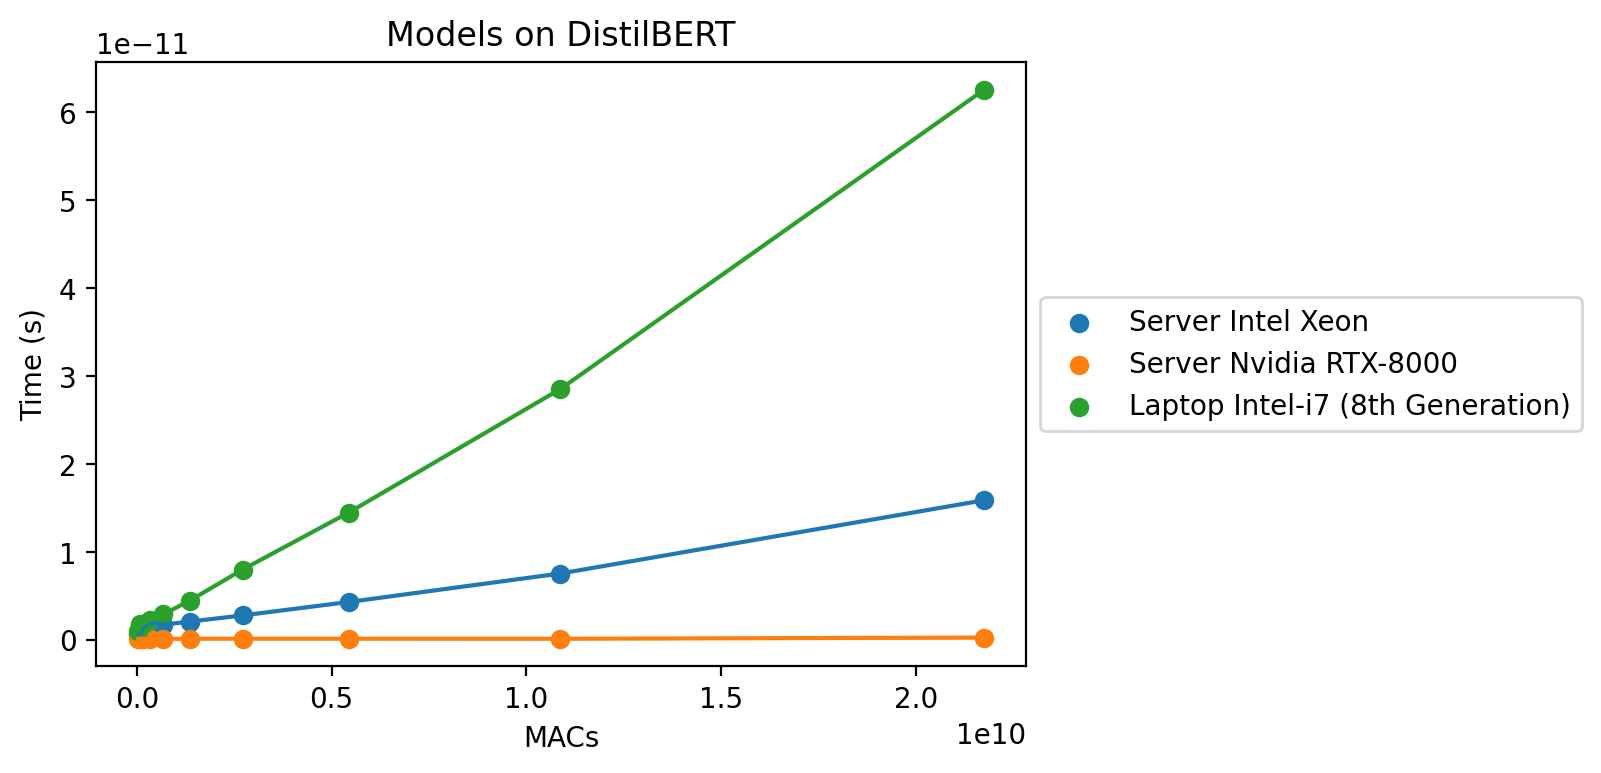

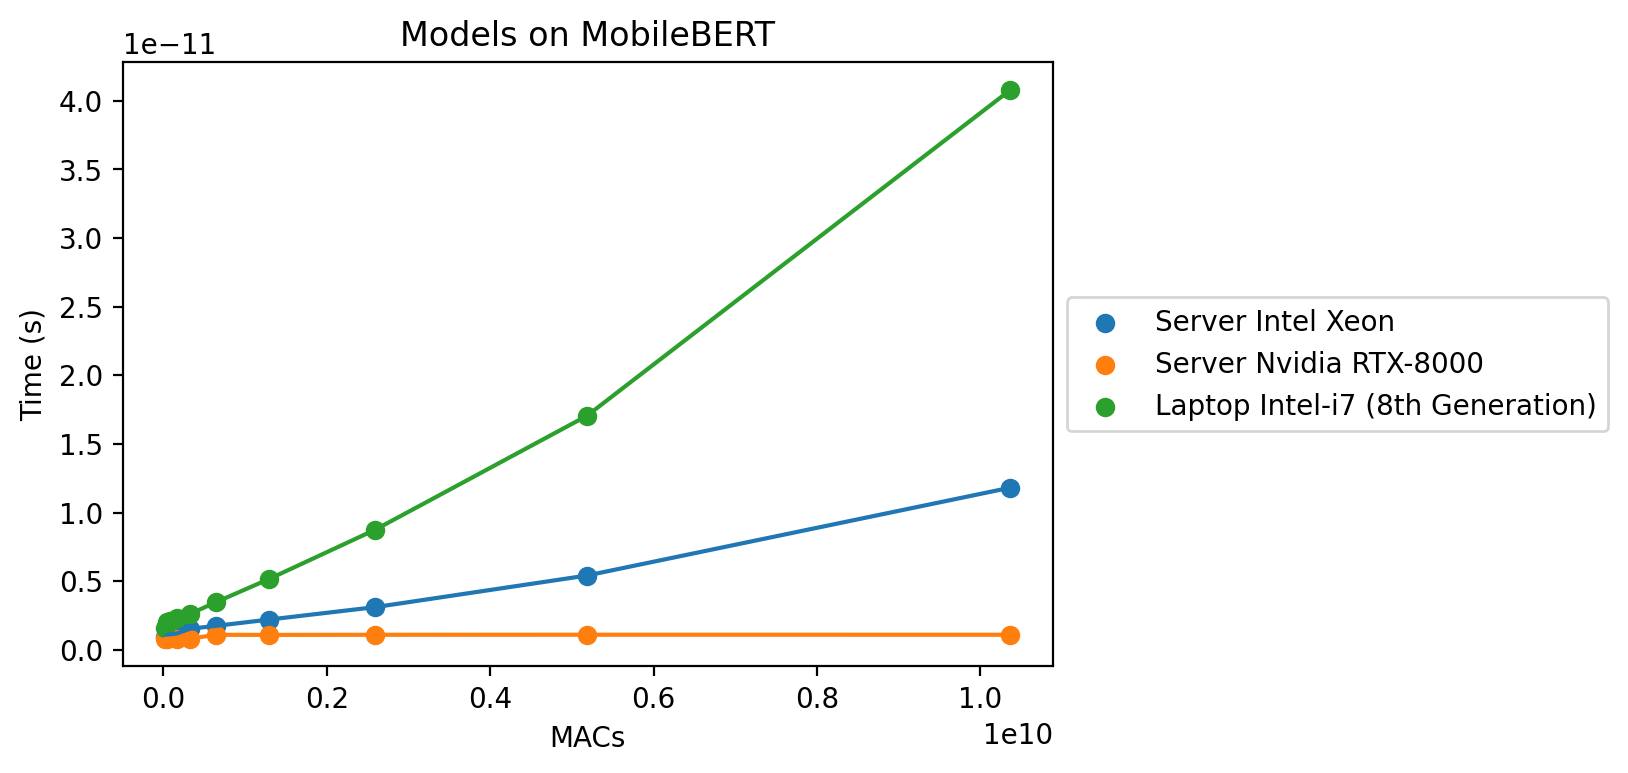

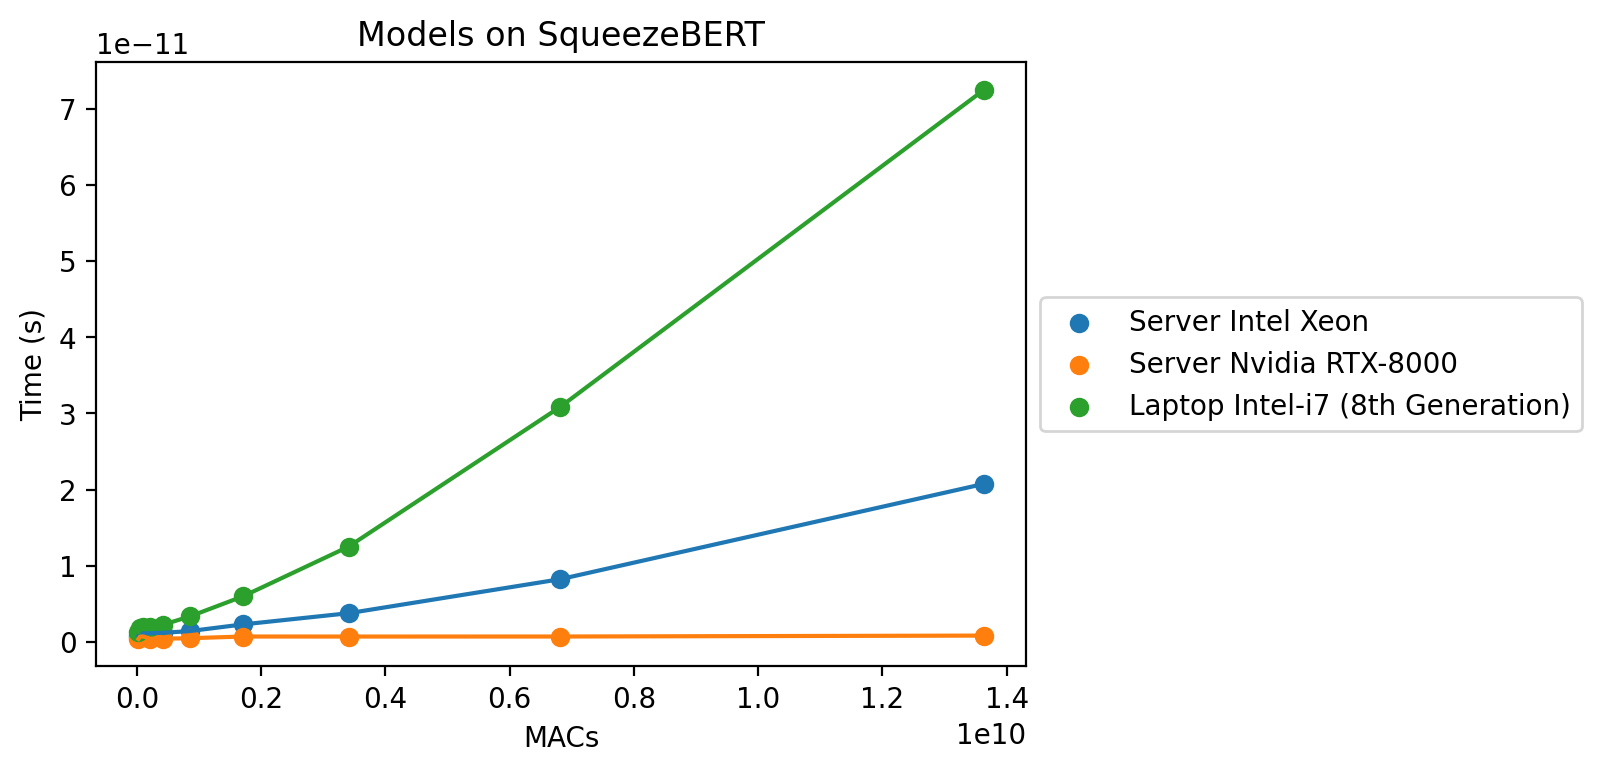

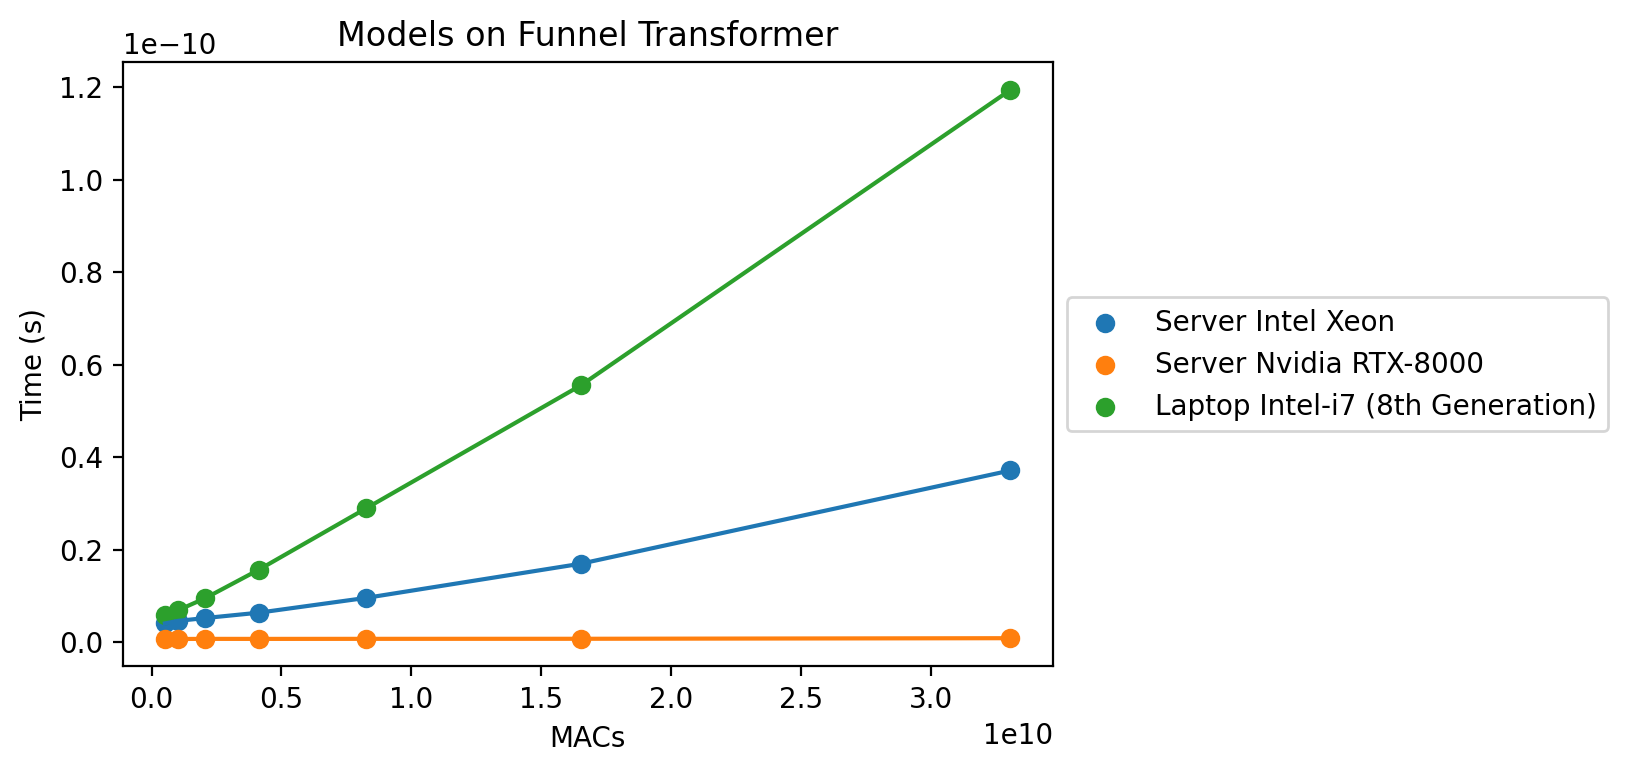

In [50]:
for model, model_name in MODELS.items():
    for device, device_name in DEVICE_LIST.items():
        results = all_results.loc[all_results['device'] == device]
        seq_lens = results.loc[results['model'] == model]['sequence_length'].tolist()
        img_size = results.loc[results['model'] == model]['img_size'].tolist()
        avg_memory = results.loc[results['model'] == model]['avg_memory'].tolist()
        mac_result = results.loc[results['model'] == model]['macs'].tolist()
        wallclock_result = results.loc[results['model'] == model]['mean']
        param_count = results.loc[results['model'] == model]['total_params'].tolist()

        x_ax, x_label = mac_result, "MACs"
        y_ax, y_label = wallclock_result/float(device_specs[device]['MemoryBandwidth']), "Time (s)"

        plt.xlabel(x_label)    
        plt.ylabel(y_label)
        plt.scatter(x_ax, y_ax, label=f"{device_name}")  
        plt.plot(x_ax,y_ax)

    plt.title(f"Models on {model_name}")
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()